# Apollo 11 - Data Prep

In [2]:
# source: https://www.hq.nasa.gov/alsj/a11/a11transcript_tec.html
# import nltk
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

from scipy.stats import gaussian_kde

This took about 20 attempts to run, finding various bad lines that wouldn't parse that I corrected in the input file, adding a few exceptions, etc.

In [3]:
file = 'a11_clean.txt'

raw = open(file, 'r')

time = []
time0 = []
speaker = []
msg = []

line = raw.readline()
cnt = 0
msgnext = False
while line:
    # check for garbage lines
    if (line[0:9] != '<br><font') & (line[0:9] != '<br><br>') & (not '--        <font' in line ):
        cnt += 1
#         print(line)

        if msgnext:
            msg.append(line.replace('<br>','').replace('\n', ''))
            msgnext = False

        if (not msgnext) & ('<font' in line):

            timeraw = line[0:11].lower()
            timeraw = timeraw.replace('o', '0') # have found this error
            timeraw = timeraw.replace('l', '1') # maybe this will happen?
            timeraw = timeraw.replace(',', '') # discovered this one

            dd = datetime.timedelta(days=int(timeraw[0:2]), hours=int(timeraw[3:5]), 
                                    minutes=int(timeraw[6:8]), seconds=int(timeraw[9:11]))
            time.append(dd)
            time0.append(datetime.datetime(year=2019,month=7,
                                           day=int(timeraw[0:2])+16, hour=int(timeraw[3:5]), 
                                           minute=int(timeraw[6:8]), second=int(timeraw[9:11])))

            pstart = line.find('0000FF')+8
            pstop = line.find('/font')-1
            speaker.append(line[pstart:pstop])

            msgnext = True
    
    # end of while loop stuff
    line = raw.readline()
raw.close()
    

In [4]:
print(len(speaker), len(time), len(msg))

8462 8462 8462


/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


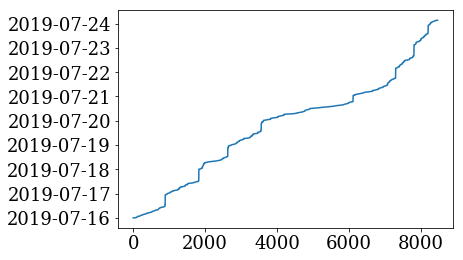

In [5]:
plt.plot(time0)

(737256.0000462963, 737264.1377083333)

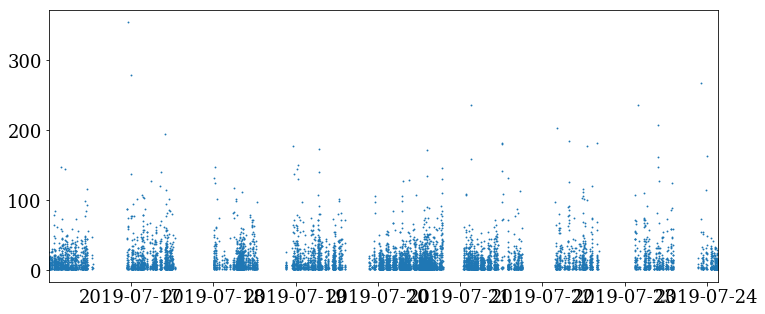

In [6]:
mlen = []
for k in range(len(time0)):
#     mlen.append(len(msg[k])) # chars
    mlen.append(len(msg[k].split(' '))) # words

plt.figure(figsize=(12,5))
plt.scatter(time0, mlen, marker='.', s=3)
plt.xlim(np.min(time0), np.max(time0))

In [43]:
sum(mlen)

118611

In [8]:
start_time = datetime.datetime(year=2019, month=7, day=16, hour=6, minute=32)
start_time

datetime.datetime(2019, 7, 16, 6, 32)

In [9]:
tlim = 260

tweets = []
tweet_times = []
for i in range(len(msg)):
    
    twt = speaker[i] +': '+ msg[i]
# len(twt) > tlim
    if len(twt) <= tlim:
        tweets.append(twt)
        tweet_times.append(start_time + time[i])
        
    else:
        words = twt.split(' ')
        sent = ''   
        toff=3
        for k in range(len(words)):
            if len(sent  + ' ' + words[k]) > tlim:
                tweets.append(sent)
                tweet_times.append(start_time + time[i])# + datetime.timedelta(seconds=toff))
                sent = ''
                toff += 3
            else:
                sent = sent+ ' ' + words[k]

        tweets.append(sent)
        tweet_times.append(start_time + time[i])# + datetime.timedelta(seconds=toff))

print('original messages:', len(msg))
print('total tweets:',len(tweets))

original messages: 8462
total tweets: 8952


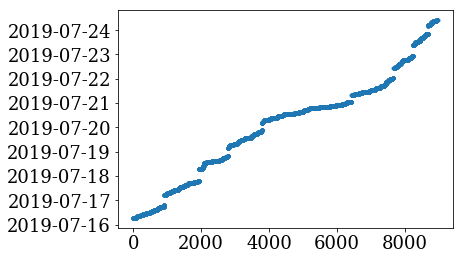

In [10]:
plt.plot(tweet_times,'.')

In [11]:
dt = np.zeros(len(tweet_times))
for i in range(len(tweet_times)):
#     datetime.timedelta.total_seconds(datetime.datetime.now() - tt)
    dt[i] = datetime.timedelta.total_seconds(tweet_times[i] - tweet_times[0])

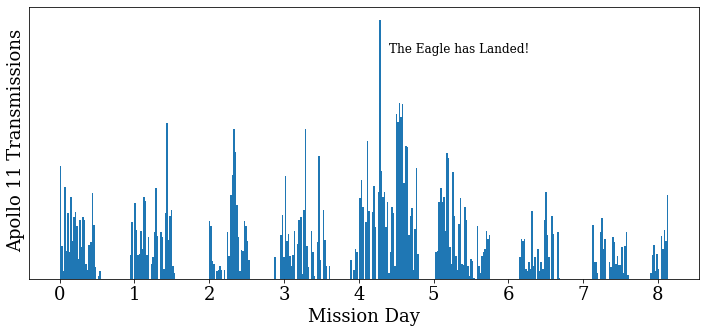

In [12]:
plt.figure(figsize=(12,5))
_ = plt.hist(dt/60/60/24, bins=400)
plt.xlabel('Mission Day')
plt.gca().axes.get_yaxis().set_visible(False)
plt.text(-.7,188,'Apollo 11 Transmissions',rotation=90)

# plt.text(0.1, 80, 'TLI', fontsize=12)
plt.text(4.4, 180, 'The Eagle has Landed!', fontsize=12)

plt.savefig('msgs.png',dpi=100, bbox_inches='tight', pad_inches=0.25)

In [13]:
print(len(tweets), dt.shape)

8952 (8952,)


In [14]:
# double check that NO tweet violates the 260char rule!
for k in tweets:
    if len(k) > tlim:
        print('OH NO!')

In [15]:
# will tweets overlap?
for k in range(len(tweet_times)-1):
    if datetime.timedelta.total_seconds(tweet_times[k+1] - tweet_times[k]) < 0:
        print(k, 'OH NO!')

Text(0, 0.5, '# Tweets')

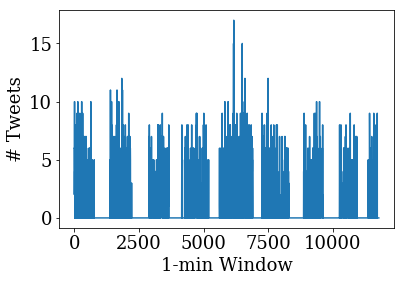

In [16]:
dt60 = np.floor_divide(dt, 60)
num, be = np.histogram(dt60, bins=np.arange(0,dt60.max()+60,1))

plt.plot(be[1:], num)
plt.xlabel('1-min Window')
plt.ylabel('# Tweets')

In [17]:
df_out = pd.DataFrame(data={'time':tweet_times, 'msg':tweets, 'sent':np.zeros(len(tweets),dtype='int')})
df_out.to_csv('msgs.csv', index=None)

## Some other plots....

In [18]:
mlens = np.zeros(len(msg))
for k in range(len(msg)):
    mlens[k] = len(msg[k].split(' '))

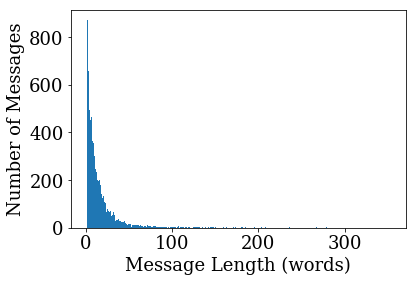

In [19]:
_ = plt.hist(mlens,bins=np.arange(max(mlens)))
plt.xlabel('Message Length (words)')
plt.ylabel('Number of Messages')

plt.savefig('nwords.png',dpi=100, bbox_inches='tight', pad_inches=0.25)

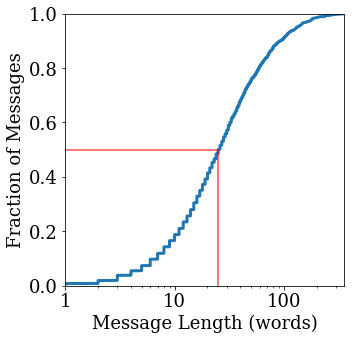

In [20]:
plt.figure(figsize=(5,5))
plt.plot(mlens[np.argsort(mlens)], np.cumsum(mlens[np.argsort(mlens)])/sum(mlens), lw=3)
plt.xlabel('Message Length (words)')
plt.ylabel('Fraction of Messages')

x50 = np.max(mlens[np.argsort(mlens)][np.cumsum(mlens[np.argsort(mlens)])/sum(mlens) <= 0.5])
plt.plot([0,x50,x50], [0.5, 0.5, 0], alpha=0.7, c='r')
plt.xlim(1,max(mlens))
plt.xscale('log')
plt.xticks([1,10,100],['1','10','100'])
plt.ylim(0,1)
plt.savefig('fracwords.png',dpi=100, bbox_inches='tight', pad_inches=0.25)

In [21]:
def word_count(searchword, messages, bw=25):
    numout = np.zeros(len(messages))
    for k in range(len(messages)):
        numout[k] = msg[k].lower().count(searchword)
    
    return numout

In [22]:
dtorig = np.zeros(len(msg))
for i in range(len(time)):
    dtorig[i] = datetime.timedelta.total_seconds(time[i])

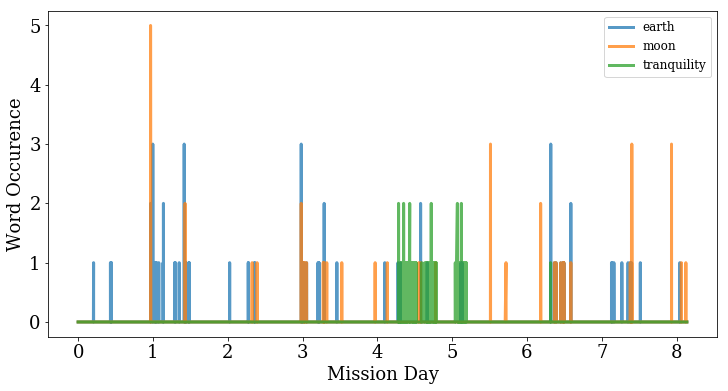

In [44]:
bag = ['earth', 'moon', 'tranquility']#, 'eagle', 'columbia']

window = 1

plt.figure(figsize=(12,6))
for k in range(len(bag)):
    plt.plot(dtorig/60/60/24,
             pd.Series(word_count(bag[k], msg)).rolling(window=window, center=True).mean(), 
             lw=3,alpha=0.75, label=bag[k])

plt.ylabel('Word Occurence')
plt.xlabel('Mission Day')
plt.legend(fontsize=12)

# plt.title(str(window)+'-pt smooth', fontsize=14)
plt.savefig('ngram1.png',dpi=100, bbox_inches='tight', pad_inches=0.25)

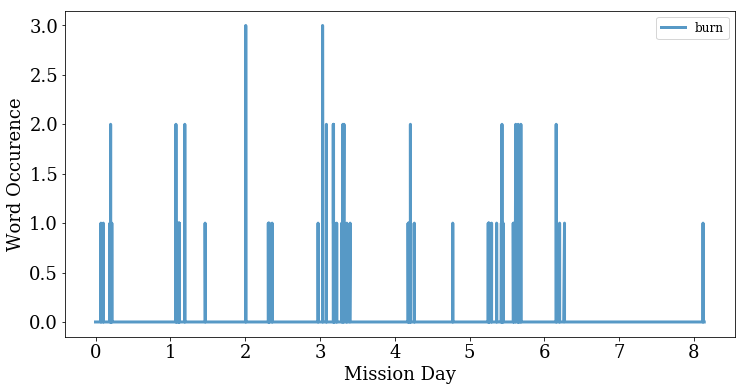

In [45]:
bag = ['burn']

window = 1
plt.figure(figsize=(12,6))
for k in range(len(bag)):
    plt.plot(dtorig/60/60/24,
             pd.Series(word_count(bag[k], msg)).rolling(window=window, center=True).mean(), 
             lw=3,alpha=0.75, label=bag[k])
plt.ylabel('Word Occurence')
plt.xlabel('Mission Day')
plt.legend(fontsize=12)
# plt.title(str(window)+'-pt smooth', fontsize=14)
plt.savefig('ngram2.png',dpi=100, bbox_inches='tight', pad_inches=0.25)

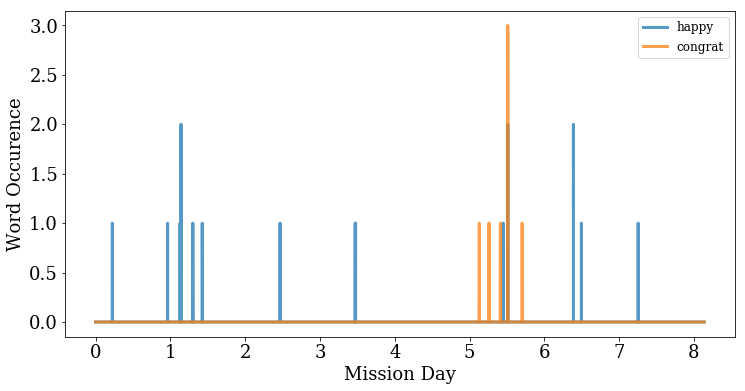

In [46]:
bag = ['happy', 'congrat']

window = 1
plt.figure(figsize=(12,6))
for k in range(len(bag)):
    plt.plot(dtorig/60/60/24,
             pd.Series(word_count(bag[k], msg)).rolling(window=window, center=True).mean(), 
             lw=3,alpha=0.75, label=bag[k])
plt.ylabel('Word Occurence')
plt.xlabel('Mission Day')
plt.legend(fontsize=12)
# plt.title(str(window)+'-pt smooth', fontsize=14)
plt.savefig('ngram3.png',dpi=100, bbox_inches='tight', pad_inches=0.25)

In [26]:
np.median(np.diff(dtorig, n=1))

9.0

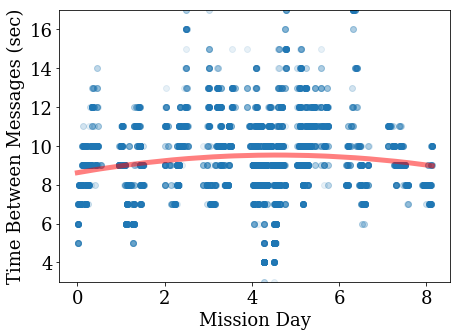

In [40]:
plt.figure(figsize=(7,5))

window = 75

plt.scatter(dtorig[1:]/60/60/24,
         pd.Series(dtorig[1:]-dtorig[0:-1]).rolling(window=window, center=True).median(), 
         alpha=0.1)

ok = np.where(np.isfinite(pd.Series(dtorig[1:]-dtorig[0:-1]).rolling(window=window, center=True).median()))[0]
ff = np.polyfit(dtorig[1:][ok]/60/60/24,
         pd.Series(dtorig[1:]-dtorig[0:-1]).rolling(window=window, center=True).median()[ok], 2)

plt.plot(dtorig[1:]/60/60/24, np.polyval(ff, dtorig[1:]/60/60/24), c='r', lw=5, alpha=0.5)

plt.xlabel('Mission Day')
plt.ylabel('Time Between Messages (sec)')
plt.ylim(3,17)
plt.savefig('delay.png',dpi=100, bbox_inches='tight', pad_inches=0.25)

In [41]:
print(np.nanmax(np.polyval(ff, dtorig[1:]/60/60/24)), np.nanmin(np.polyval(ff, dtorig[1:]/60/60/24)))

print(np.nanmax(np.polyval(ff, dtorig[1:]/60/60/24)) - np.nanmin(np.polyval(ff, dtorig[1:]/60/60/24)))



9.528029220238643 8.618912152902642
0.9091170673360018
